# A2C (Advantage Actor-Critic)
- 이는 A3C라는 알고리즘에서 파생된 분산학습형 심층강화학습 알고리즘이다.
- 이는 에이전트를 여러개 사용해서 학습을 진행하며 모든 에이전트가 같은 신경망을 공유한다.
- Advantage 학습은 Q함수를 학습할 때 2단계 이상 미래의 행동가치까지 계산에 넣는 것이 핵심이다.
- Advantage 학습을 위한 수정식 `Q(s_t, a_t) -> R(t+1) + r * R(t+2) + r^2 * max_a[Q(s_t+2, a)]`
- 여기서 주의해야 할 것이 단순히 미래 여러단계를 넣으면 될 수 있겠다 생각할 수 있겠지만 그러면 그 단계 수만큼 행동을 결정해야한다.
- 그 행동을 결정하기 위해 Q함수를 사용하므로 지금은 적절한 행동을 선택하지 못할 확률이 높고 그에 따라 학습이 잘못될 가능성이 있다. 따라서 적절한 단계수를 선택하는 것이 일반적이다.

- Actor-Critic은 정책반복과 가치반복 알고리즘을 조합한 것이다. (Actor의 경우 출력 수 는 행동의 가짓수, Critic의 출력은 상태가치 값)
- 정책 반복이란 정책에 따라 목표에 빠르게 도달했던 경우에 수행했던 행동(action)을 중요한 것으로 보고, 이때의 행동을 앞으로도 취할 수 있도록 정책을 수정하는 방법이다.
    - 소프트맥스 함수, 정책 경사 알고리즘이 있다.
- 가치 반복이란 목표 지점부터 거슬러 올라가며 목표 지점과 가까운 상태로 에이전트를 유도해 오는 방법이다. 즉, 목표지점외의 지점에도 가치를 부여하는 것이다.
    - 가치 반복은 행동가치와 상태가치로 나누어 볼 수 있다.
    - 상태가치란 상태 s에서 정책ㅠ(파이)을 따라 이동할 때 얻으리라 기대할 수 있는 할인 총보상 G_t의 기댓값을 말한다. 일반적으로 이 값은 벨만 방정식을 따른다.
    - 행동가치란 상태 s에서 어떤 행동 a를 했을 때 얻으리라 기대할 수 있는 할인 총보상 G_t의 기댓값을 말한다. 행동 가치도 역시 벨만 방정식을 따른다.

- 아래의 그림은 A2C, A3C에 대한 그림이다.
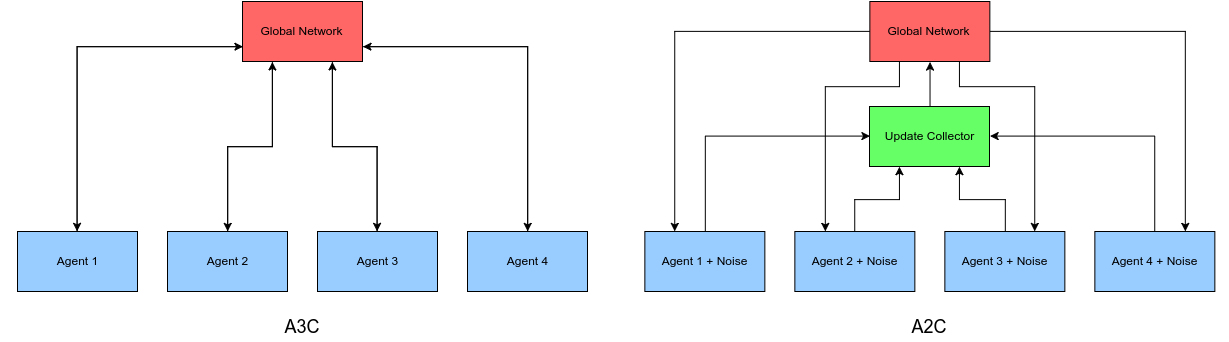

이 코드에서 사용된 수식에 대한 자세한 정보는 아래의 URL을 참고하면 된다. <br>
[URL] : http://incredible.ai/reinforcement-learning/2019/07/20/Advantage-A2C/

In [32]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import gym

In [33]:
ENV = 'CartPole-v0'
GAMMA = 0.99
MAX_STEPS = 200
NUM_EPISODES = 1000

NUM_PROCESSES = 32 # 동시 실행 환경 수 (32 agent 사용)
NUM_ADVANCED_STEP = 5 # 총 보상을 계산할 때 Advantage학습을 할 단계 수(미래 5단계까지 고려)
# A2C 손실 함수 계산에 사용되는 상수
value_loss_coef = 0.5
entropy_coef = 0.01
max_grad_norm = 0.5

In [34]:
# 메모리 클래스 정의
class RolloutStorage(object):
    def __init__(self, num_steps, num_processes, obs_shape):
        self.observations = torch.zeros(num_steps + 1, num_processes, 4)
        self.masks = torch.ones(num_steps + 1, num_processes, 1) # 해당 단계가 에피소드의 끝인지 여부를 표시하기 위한 변수 다음 단계가 존재하면 1 아니면 0값을 가짐
        self.rewards = torch.zeros(num_steps, num_processes, 1)
        self.actions = torch.zeros(num_steps, num_processes, 1).long() # long() 형으로 변환
        # 할인 총 보상 저장
        self.returns = torch.zeros(num_steps + 1, num_processes, 1)
        self.index = 0 # insert할 인덱스
        
    def insert(self, current_obs, action, reward, mask):
        # 이 함수에서 아래의 코드는 각 단계에서 얻은 값들을 복사하여 저장을 한다.
        # 예를 들어 actions의 shape : (num_steps, num_processes, 1)인데 이를 (index, num_processes, 1)처럼 접근하여 저장을 하겠다는 의미이다.
        self.observations[self.index + 1].copy_(current_obs) # 현재 상태에서 어떤 행동을 취했을 때 다음 상태 저장
        self.masks[self.index + 1].copy_(mask) # 에피소드가 끝났는지 확인
        self.rewards[self.index].copy_(reward) # 현재 상태에서 얻음 보상
        self.actions[self.index].copy_(action) # 현재 상태에서 취한 행동
        
        self.index = (self.index + 1) % NUM_ADVANCED_STEP
        
    def after_update(self): 
        # Advantage만큼 학습 단계가 진행되면 가장 새로운 transition을 index0에 저장
        self.observations[0].copy_(self.observations[-1]) # (5, 1, 2, 3, 4)
        self.masks[0].copy_(self.masks[-1]) # (5, 1, 2, 3, 4)
        
    def compute_returns(self, next_value):
        # 주의 : 5번쩨 단계 부터 거슬러 올라오며 계산
        # 주의 : 5번째 단계가 Advantage1, 4번째 단계는 Advantage2가 됨
        self.returns[-1] = next_value
        for ad_step in reversed(range(self.rewards.size(0))):
            self.returns[ad_step] = self.returns[ad_step + 1] * GAMMA * self.masks[ad_step + 1] + self.rewards[ad_step]

In [35]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self, n_in, n_mid, n_out):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(n_in, n_mid)
        self.fc2 = nn.Linear(n_mid, n_mid)
        self.actor = nn.Linear(n_mid, n_out) # 행동을 결정하는 부분이므로 출력개수는 행동의 가짓수
        self.critic = nn.Linear(n_mid, 1) # 상태 가치를 출력하는 부분이므로 출력개수는 1개
        
    def forward(self, x):
        h1 = F.relu(self.fc1(x))
        h2 = F.relu(self.fc2(h1))
        critic_output = self.critic(h2) # 상태가치 계산
        actor_output = self.actor(h2) # 행동가치 계산,상태 s_t를 입력받고 이 상태에서 각 행동이 얼마나 좋은지를 출력
        return critic_output, actor_output # 상태가치 출력과 행동가치 출력을 반환함
    
    def act(self, x): # 상태 x에 대해서 확률적으로 행동을 결정함
        value, actor_output = self(x)
        
        # 위에서 얻은 상태 s_t에서의 행동에 대한 값을 소프트맥스 값에 적용함으로써
        # 상태 s_t에서 적절한 행동이 될 확률 ㅠ(s_t, a)가 된다.
        action_probs = F.softmax(actor_output, dim=1) # dim=1이므로 행동의 종류에 대해 softmax를 적용
        # multinomial()함수는 행을 기준으로 sampling을 한다. 따라서 (m * n)과 같은 행렬이 있을 때 이 함수를 사용하면 (m * num_samples)처럼 만들어진다.
        # 그리고 위 함수는 샘플링된 값의 인덱스를 반환한다.
        action = action_probs.multinomial(num_samples=1)
        return action
    
    def get_value(self, x): # 상태 x의 상태가치를 계산함
        value, actor_output = self(x)
        return value
    
    def evaluate_actions(self, x, actions): # 신경망의 가중치를 수정함
        # 상태 x로 부터 상태가치, 실제행동 actions의 로그 확률, 엔트로피를 계산
        value, actor_output = self(x)
        
        # log_softmax는 softmax 함수를 적용하고 그 값에 log를 취한 것이다.
        log_probs = F.log_softmax(actor_output, dim=1) # 행동의 종류에 대해서 확률을 계산
        action_log_probs = log_probs.gather(1, actions)
        
        probs = F.softmax(actor_output, dim=1) # 행동의 종류에 대해서 확률을 계산
        entropy = -(log_probs * probs).sum(-1).mean() # Actor_entropy 계산 식
        
        return value, action_log_probs, entropy

In [36]:
import torch
from torch import optim
class Brain(object):
    def __init__(self, actor_critic):
        self.actor_critic = actor_critic
        self.optimizer = optim.Adam(self.actor_critic.parameters(), lr = 0.01)
    
    def update(self, rollout):
        # Advantage 학습의 대상이 되는 5단계 모두를 사용해서 수정
        obs_shape = rollout.observations.size()[2:] # Tensor(Size([5 + 1, 32, 4]))
        num_steps = NUM_ADVANCED_STEP
        num_processes = NUM_PROCESSES
        
        # rollout.observations[:-1].reshape(-1, 4) ==> shape : (5 * 32, 4) = (160, 4)
        # rollout.actions.reshape(-1, 1) ==> shape : (5 * 32, 1) = (160, 1)
        values, action_log_probs, entropy = self.actor_critic.evaluate_actions(rollout.observations[:-1].reshape(-1, 4),
                                                                              rollout.actions.reshape(-1, 1))
        values = values.reshape(num_steps, num_processes, 1)
        action_log_probs = action_log_probs.reshape(num_steps, num_processes, 1)
        
        # Advantage계산
        # 여기서 returns변수는 할인 총보상에 대한 정보를 가지고 있는 변수이다.
        # returns변수에서 마지막 값을 제외한 이유는 values와 형태를 맞추려는 이유도 있지만 
        # 더 중요한 이유로는 returns의 계산 방식에 있다.
        # returns는 마지막에 다음 다음 상태가치 함수값 V(s_t+1)을 집어넣는다. 따라서 returns변수의 마지막 값은 행동가치함수의 값이 아니기 때문에 제외하고 연산을 해야한다.
        advantage = rollout.returns[:-1] - values
        # 행동가치 Critic의 loss 계산
        value_loss = advantage.pow(2).mean()
        
        # Actor의 gain계산, 나중에 -1을 곱하면 loss 가 된다.
        # action_gain은 상수 취급을 위해 detach()를 사용했다.
        # 아래서 구한 것은 J(theta, s_t)이다.
        policy_loss = (action_log_probs * advantage.detach()).mean() # Q^ㅠ(s, a) * log(ㅠ_theta(a|s))
        
        # 오차함수의 총합
        # 할인 총 보상을 정책 경사 알고리즘을 사용하여 나타낸 식에서 로그 식을 분배하여 사용을 한다.
        # 오차함수의 총 합은 J(theta, s_t) + loss_Critic + Actor_entropy이다.
        total_loss = (value_loss * value_loss_coef - policy_loss - entropy * entropy_coef)
        
        # 결합 가중치 수정
        self.actor_critic.train() # 훈련 모드로 변경
        self.optimizer.zero_grad()
        total_loss.backward()
        # 결합 가중치가 한번에 너무 크게 변화하지 않도록 경사를 0.5이하로 제한(클리핑)
        # 이는 RNN계열에서 gradient elploding을 방지하여 학습의 안정화를 도모하기 위해 사용하는 방법이다.
        # 이를 사용하지 않으면 gradient가 너무 뛰어서 global minimum에 도달하지 못하고 엉뚱한 방향으로 향하게 되게 되지만
        # cliping을 하면 gradient vector가 방향은 유지하면서 적은 값만큼 이동하여 도달하려는 곳으로 안정적으로 내려가게 된다.
        # nn.util.clip_grad_norm_(parameter, max_grad_norm)함수에서 max_grad_norm은 cliping을 적용할 기준을 의미한다. 
        # max_grad_norm이상에 대해 cliping을 한다는 의미이다.
        nn.utils.clip_grad_norm_(self.actor_critic.parameters(), max_grad_norm)
        self.optimizer.step()

In [42]:
import copy
class Environment:
    def run(self):
        envs = [gym.make(ENV) for i in range(NUM_PROCESSES)]
        
        # 모든 agent가 공유하는 Brain객체를 생성
        n_in = envs[0].observation_space.shape[0] # 상태 변수 수는 4
        n_out = envs[0].action_space.n # 행동 가짓수는 2
        n_mid = 32
        actor_critic = Net(n_in, n_mid, n_out) # 신경망 객체 생성
        global_brain = Brain(actor_critic)
        
        # 각종 정보를 저장하는 함수
        obs_shape = n_in
        current_obs = torch.zeros(NUM_PROCESSES, obs_shape) # torch.Size([32, 4])
        rollout = RolloutStorage(NUM_ADVANCED_STEP, NUM_PROCESSES, obs_shape)
        episode_rewards = torch.zeros([NUM_PROCESSES, 1]) # 현재 에피소드의 보상
        final_rewards = torch.zeros([NUM_PROCESSES, 1]) # 마지막 에피소드의 보상
        obs_np = np.zeros([NUM_PROCESSES, obs_shape])
        reward_np = np.zeros([NUM_PROCESSES, 1])
        done_np = np.zeros([NUM_PROCESSES, 1])
        each_step = np.zeros(NUM_PROCESSES) # 각 환경의 단계 수를 기록
        episode = 0
        
        # 초기 상태로 부터 시작
        obs = [envs[i].reset() for i in range(NUM_PROCESSES)]
        obs = np.array(obs)
        obs = torch.from_numpy(obs).float() # torch.Size([32, 4])
        current_obs = obs # 가장 최근의 obs를 저장
        
        # advanced 학습에 사용되는 rollouts 객체에는 첫번째 상태에 현재 상태를 저장
        rollout.observations[0].copy_(current_obs)
        
        # list1 = [[] for i in range(NUM_PROCESSES)]
        # 에피소드 반복문
        for j in range(NUM_EPISODES * NUM_PROCESSES): # 1000 * 32번 실행 : 각각의 에이전트에 대해서 NUM_EPISODES만큼 반복을 하므로 NUM_EPISODES * NUM_PROCESSES만큼 반복함 
            # advanced 학습 대상이 되는 가 단계에 대해 계산
            for step in range(NUM_ADVANCED_STEP): # 이 for문의 역할은 총 32개의 Agent들에 대해서 5단계의 미래 행동에 대한 할인 총보상을 구하기 위한 반복문
                # 행동을 선택
                with torch.no_grad(): # 미분 없이 현재 상태에 대한 행동을 구함
                    action = actor_critic.act(rollout.observations[step])
                actions = action.squeeze(1).numpy() # Tensor를 numpy로 
                
                # 모든 Agent에 대해서 현재 행동에 대한 다음 상태와 보상, 끝 여부를 얻고 done여부에 따른 보상과 단계 얻음
                for i in range(NUM_PROCESSES): # 32개의 Agent들에 대해 실행
                    obs_np[i], reward_np[i], done_np[i], _ = envs[i].step(actions[i]) # info 정보는 사용하지 않음
                    if done_np[i]:
                        if i == 10:
                            print(f"{episode} Episode : Finished after {each_step[i] + 1}")
                            episode += 1
                        #list1[i].append(f"{episode} Episode : Finished after {each_step[i] + 1}")
                        #episode += 1
                        if each_step[i] < 195:
                            reward_np[i] = -1.0
                        else:
                            reward_np[i] = 1.0
                        # 현재 에이전트에서 게임이 끝나면 게임의 단계수를 초기화하고 게임을 리셋한다.
                        each_step[i] = 0 # 단계수 초기화
                        obs_np[i] = envs[i].reset()
                    else:
                        reward_np[i] = 0.0
                        each_step[i] += 1
                # 보상을 Tensor로 변환하고, 에피소드의 총 보상에 더해줌
                reward = torch.from_numpy(reward_np).float()
                episode_rewards += reward # 현재 에피소드에서 각각의 에이전트에 대한 보상을 구한 값을 더함
                
                # 각 실행 환경을 확인해서 done이 true면 mask를 0으로 ,false이면 maks를 1로 한다.
                masks = torch.FloatTensor([[0.0] if done_ else [1.0] for done_ in done_np])
                
                # 마지막 에피소드의 총 보상을 업데이트
                # 최종 보상에 masks를 곱함으로써 게임이 끝난 에이전트에 대해서는 보상이 리셋되고 아직끝나지 않는 부분에 대해서는 그대로 보상을 남긴다.
                final_rewards *= masks
                final_rewards += (1 - masks) * episode_rewards
                
                # 에피소드의 총 보상을 업데이트
                episode_rewards *= masks
                
                # 현재 done이 True면 모두 0으로
                current_obs *= masks
                
                # current_obs를 업데이트
                obs = torch.from_numpy(obs_np).float()
                current_obs = obs # 최신 상태의 obs를 저장
                
                # 메모리 객체에 현 단계의 transition을 저장
                rollout.insert(current_obs, action.data, reward, masks)
            # Advantage 학습 대상중 마지막 단계의 상태로 예측하는 상태가치를 계산
            
            with torch.no_grad(): # 마지막 관찰 값(상태 값)을 집어넣어 다음 가치함수 값을 얻는다. 
                next_value = actor_critic.get_value(rollout.observations[-1]).detach()
            rollout.compute_returns(next_value) # 모든 단계의 할인 총 보상을 계산하고, rollouts의 returns 변수를 업데이트
            
            # 신경망 및 rollout 업데이트
            global_brain.update(rollout)
            rollout.after_update()
            
            # 환경 개수를 넘어서는 횟수로 200 단계를 버텨내면 성공
            if final_rewards.sum().numpy() >= NUM_PROCESSES:
                #print(list1)
                print('연속 성공')
                break

In [43]:
# main 실행
cartpole_env = Environment()
cartpole_env.run()

0 Episode : Finished after 21.0
1 Episode : Finished after 14.0
2 Episode : Finished after 23.0
3 Episode : Finished after 43.0
4 Episode : Finished after 14.0
5 Episode : Finished after 16.0
6 Episode : Finished after 58.0
7 Episode : Finished after 16.0
8 Episode : Finished after 13.0
9 Episode : Finished after 16.0
10 Episode : Finished after 11.0
11 Episode : Finished after 17.0
12 Episode : Finished after 75.0
13 Episode : Finished after 110.0
14 Episode : Finished after 134.0
15 Episode : Finished after 200.0
16 Episode : Finished after 91.0
17 Episode : Finished after 200.0
18 Episode : Finished after 169.0
19 Episode : Finished after 200.0
20 Episode : Finished after 153.0
21 Episode : Finished after 28.0
22 Episode : Finished after 86.0
23 Episode : Finished after 200.0
24 Episode : Finished after 88.0
25 Episode : Finished after 200.0
26 Episode : Finished after 112.0
27 Episode : Finished after 128.0
28 Episode : Finished after 120.0
29 Episode : Finished after 200.0
연속 성공
